# Reinforcement Learning Final Project 

Welcome to your Reinforcement Learning project focused on developing an RL agent capable of playing chess at a strategic level. Chess has long been considered a benchmark for measuring AI capabilities, and this project aims to leverage the power of RL to create an intelligent agent that can make optimal decisions in complex chess positions. By combining the principles of reinforcement learning with the rich strategic domain of chess, you will explore new approaches to create the most effective chess player.

## Project Objectives:

* Train an RL agent to play chess: The primary objective of this project is to develop an RL agent that can play chess at a high level of proficiency. The agent should be capable of evaluating chess positions and making strategic decisions.

* Optimize decision-making using RL algorithms: Explore different RL algorithms, as seen in class, to train the agent. Compare and analise their effectiveness in learning and decision-making capabilities in the context of chess.

* Use a challenging chess environment: Use a comprehensive environment for the agent to interact with, representing the rules and dynamics of chess. This environment will provide a realistic and challenging setting for the agent's training and evaluation.

* Evaluate and benchmark performance: Assess the performance of the RL agent against different benchmarks from existing chess engines. You will compare your agent's performance to established chess engines to measure progress and identify areas for improvement.


### Extra Objectives:

* Investigate transfer learning and generalization: Explore techniques for transfer learning to leverage knowledge acquired in related domains or from pre-training on large chess datasets. Investigate the agent's ability to generalize its knowledge.

* Enhance interpretability and analysis: Develop methods to analise the agent's decision-making process and provide insights into its strategic thinking. Investigate techniques to visualize the agent's evaluation of chess positions and understand its reasoning behind specific moves.

## The [Environment](https://github.com/iamlucaswolf/gym-chess)

The environment gym-chess provides OpenAI Gym environments for the game of Chess. It comes with an implementation of the board and move encoding used in AlphaZero. 

Please install it using the command: 

`pip install gym-chess`

In [1]:
import chess
import gym
import gym_chess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
import random
from collections import deque
import cv2
import time
from tqdm.notebook import tqdm
from moviepy.editor import ImageSequenceClip
from IPython.display import clear_output
from gym_chess.alphazero.move_encoding import MoveEncoding

### A Two player's game

As you know chess is played by two players, as such the gym-chess environment gives you access to both players actions in a sequential matter.

#### The agent receives a reward of +1 when the white player makes a winning move, and a reward of -1 when the black player makes a winning move. 

All other rewards are zero.

### Evaluationg your agent with [Stockfish](https://github.com/zhelyabuzhsky/stockfish)

In order to have a good enough idea that our agent is actually playing well we need a benchmarkable opponent.

As such we need to install stockfish a free and open-source chess engine. Stockfish has consistently ranked first or near the top of most chess-engine rating lists and, as of April 2023, is the strongest CPU chess engine in the world.

`pip install stockfish`


In [2]:
from stockfish import Stockfish

StockFish has a python api as seen above, nevertheless the engine still needs to be downloaded [here](https://stockfishchess.org/download/) and used in the path.

NOTE: You were given an engine already in moodle, nevertheless different computer systems (Windows, Mac, Ubuntu) might require other Stockfish engines.

In [3]:
Stockfish_path = "C:/Users/mafal/OneDrive/Documents/Mestrado/2nd Semester/WIP/Reinforcement Learning/Final Project Materials-20230531/stockfish_15.1_win_x64_avx2/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2"

The functions bellow generate episodes/games for a WHITE or BLACK Pieces Scenario respectively. We store the outcome of the episode (win/draw/loss) and the number of steps taken.

#### Notice how the AGENT_POLICY function is used it recieves as inputs the env and the current state.
`action = AGENT_POLICY(env, state)`

In [4]:
#state_size
env = gym.make(
    "ChessAlphaZero-v0"
) 
state_size = env.observation_space.shape

state_size

(8, 8, 119)

In [5]:
# number of actions
action_size = env.action_space.n

action_size

4672

In [6]:
action_space = env.action_space

action_space

Discrete(4672)

In [31]:
class DQN_Agent:
    def __init__(self, state_size, action_size):
        
        #define the state size
        self.state_size = state_size
        
        #define the action size
        self.action_size = action_size
        
        #define the replay buffer
        self.replay_buffer = deque(maxlen=1000)
        
        #define the discount factor
        self.gamma = 0.9
        
        #define the epsilon value
        self.epsilon = 0.99
        
        #define the update rate at which we want to update the target network
        self.update_rate = 5
        
        #define the main network
        self.main_network = self.build_network()
        
        #define the target network
        self.target_network = self.build_network()
        
        #copy the weights of the main network to the target network
        self.target_network.set_weights(self.main_network.get_weights())

        #learning rate
        self.learning_rate = .0001
        

    #Let's define a function called build_network which is essentially our DQN. 
    def build_network(self):
        model = Sequential()

        model.add(Dense(64, activation='relu', input_shape=self.state_size))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001, epsilon=1e-7))

        return model


    #We learned that we train DQN by randomly sampling a minibatch of transitions from the
    #replay buffer. So, we define a function called store_transition which stores the transition information
    #into the replay buffer
    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
        
        

    #We learned that in DQN, to take care of exploration-exploitation trade off, we select action
    #using the epsilon-greedy policy. So, now we define the function called epsilon_greedy
    #for selecting action using the epsilon-greedy policy.
    def epsilon_greedy(self, state, legal_actions):

        if random.uniform(0, 1) < self.epsilon:
            # Randomly select a legal move from the action space
            random_action = np.random.choice(legal_actions)
            
            return random_action

        # Use your Q-network to predict the Q-values for the state
        Q_values = self.main_network.predict(np.expand_dims(state, axis=0), verbose=0)

        if isinstance(Q_values, int):
            return Q_values
        else:
            return np.random.choice(legal_actions)

    
    #train the network
    def train(self, batch_size, legal_actions):
        minibatch = np.array(random.sample(self.replay_buffer, batch_size), dtype=object)
        state_list = np.stack(minibatch[:, 0])  # Stack elements along a new axis
        next_state_list = np.array([np.array(next_state) for next_state in minibatch[:, 3]], dtype=np.float32)
        
        current_Q_values_list = self.main_network.predict(state_list, verbose=0)
        max_q = np.amax(self.target_network.predict(next_state_list, verbose=0), axis=1)

        for i, zip_ in enumerate(minibatch):
            state, action, reward, next_state, done = zip_

            if not done:
                target  = reward + self.gamma * max_q[i]
            else:
                target = reward
            
            # Check if the action is within the valid range of actions
            if np.any(action >= self.action_size):
                new_shape = (current_Q_values_list.shape[0], action + 1) + current_Q_values_list.shape[2:]  # Increase the size of the second dimension
                new_Q_values_list = np.zeros(new_shape)
                new_Q_values_list[:, :current_Q_values_list.shape[1], ...] = current_Q_values_list  # Copy the values from the original array
                current_Q_values_list = new_Q_values_list
                current_Q_values_list[i, action.astype(int)] = target

            # Ensure action is within the valid range
            if np.any(action < current_Q_values_list.shape[1]):
                current_Q_values_list[i, action.astype(int)] = target
        

        #train the main network
        self.main_network.fit(state_list, current_Q_values_list, epochs=1, verbose=0)
            

    #update the target network weights by copying from the main network
    def update_target_network(self):
        self.target_network.set_weights(self.main_network.get_weights())    

Episode: 10, epsilon = 0.94500, learning rate = 0.00010, gamma = 0.90000


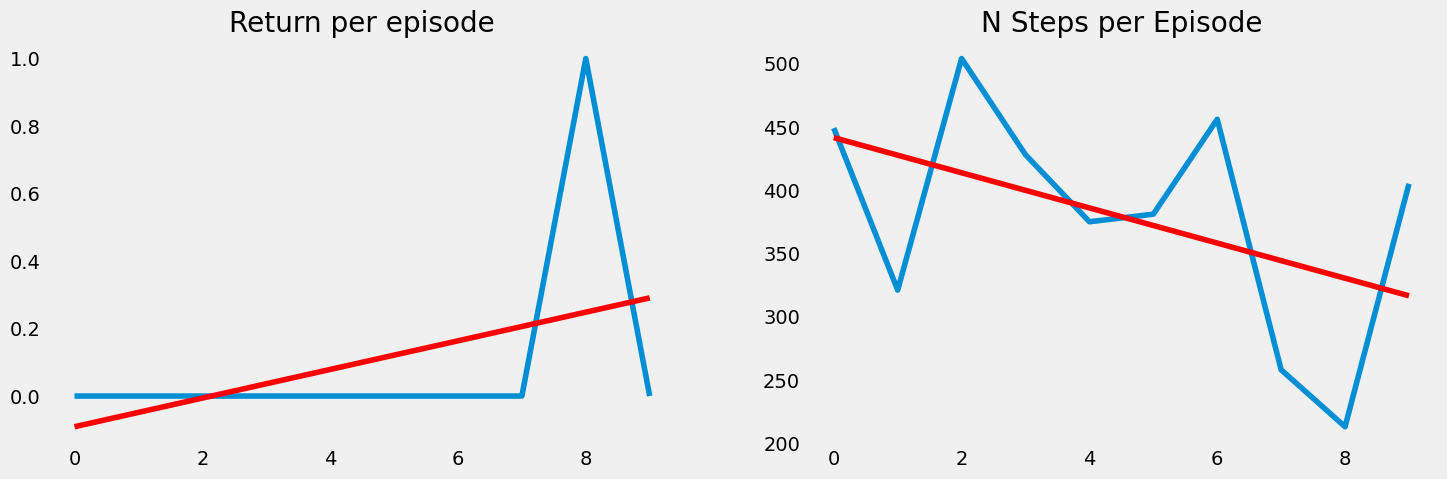

In [41]:
#TRAINIG THE NETWORK
num_episodes = 100

# Defining the number of time steps
num_timesteps = 200

# Defining the batch size:
batch_size = 128

# Defining the environment and state
env = gym.make("ChessAlphaZero-v0")
state = env.reset()

#Defining the agent
dqn_agent = DQN_Agent(state_size=env.observation_space.shape, action_size=env.action_space.n)

return_list = []
n_steps_list = []

#for each episode
for i in tqdm(range(1, num_episodes+1)):
    
    #set return to 0
    Return = 0
    Real_Return = 0
    
    state = env.reset()
    
    done = False
    time_step = 0
    negative_reward_counter = 0
    
    #for each step in the episode
    while not done:
        
        #update the time step
        time_step += 1
        
        #update the target network
        if i % dqn_agent.update_rate == 0:
            dqn_agent.update_target_network()
        
        #select the action
        action = dqn_agent.epsilon_greedy(state, env.legal_actions)
        
        #perform the selected action
        next_state, reward, done, info = env.step(action)

        real_reward = reward
        
        #store the transition information
        dqn_agent.store_transition(state, action, reward, next_state, done)
        
        #update current state to next state
        state = next_state
        
        #update the return
        Return += reward
        Real_Return += real_reward
        
        # If continually getting negative reward 25 times after the tolerance steps, terminate this episode
        negative_reward_counter = negative_reward_counter + 1 if time_step > 100 and reward < 0 else -1
            
        #if the episode is done then print the return
        if done | (negative_reward_counter >= 25):
            print('Episode: ',i, ', Return:', round(Return), 'Steps:', time_step, 'Epsilon:', round(dqn_agent.epsilon,2), '\n')
            break
            
        #if the number of transitions in the replay buffer is greater than batch size
        #then train the network
        if (len(dqn_agent.replay_buffer) > batch_size) & (time_step % 10 == 0): # Only train each 10 steps
            dqn_agent.train(batch_size, env.legal_actions)
    
    return_list.append(Real_Return)
    n_steps_list.append(time_step)
    

    if i % 20 == 0:
        #Experimenting with different gammas
        dqn_agent.gamma = random.uniform(0.5, 0.9)

        #Experimenting with different learning rates
        dqn_agent.learning_rate = random.uniform(0.0001, 0.01)
        
    if i % 5 == 0:
        # eval the agent
        clear_output(True)
        print(f"Episode: %i, epsilon = %.5f, learning rate = %.5f, gamma = %.5f" %
              (i, dqn_agent.epsilon, dqn_agent.learning_rate, dqn_agent.gamma))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Return per episode")
        plt.plot(return_list)
        z = np.polyfit(range(i), return_list, 1)
        p = np.poly1d(z)
        #add trendline to plot
        plt.plot(range(i), p(range(i)), color='red')
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.title("N Steps per Episode")
        plt.plot(n_steps_list)
        z = np.polyfit(range(i), n_steps_list, 1)
        p = np.poly1d(z)
        #add trendline to plot
        plt.plot(range(i), p(range(i)), color='red')
        plt.grid()

        plt.show()
        
    dqn_agent.epsilon -= .005 
    dqn_agent.epsilon = max(dqn_agent.epsilon, .2)


In [ ]:
import pickle

# save the agent as a pickle file
model_pkl_file = "model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(dqn_agent, file)

In [ ]:
with open(model_pkl_file, 'rb') as file:  
    model = pickle.load(file)

In [22]:
def generate_WHITE_scenario(Stockfish_path, agent):
    env = gym.make(
        "ChessAlphaZero-v0"
    )  # We will use Alpha Zero's numenclature for the actions encodings
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(100)  # Default "skill" level is 1350, higher will increase the skill of stockfish "player". See more at https://en.wikipedia.org/wiki/Elo_rating_system

    state = env.reset()
    done = False
    counter = 0  # Since each step represents a play in a chess game we are going to store the number of steps associated to the episode/game

    while not done:
        if counter % 2 == 0:  # If the step number is pair, this means that it is the WHITE player's turn
            action = agent.epsilon_greedy(state, env.legal_actions)
            decoded_action = env.decode(action)
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        else:  # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        counter += 1
        state= next_state

    env.close()

    return reward, np.ceil(counter / 2)


def generate_BLACK_scenario(Stockfish_path, agent):
    env = gym.make(
        "ChessAlphaZero-v0"
    )  # We will use Alpha Zero's numenclature for the actions encodings
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(100)  # Default "skill" level is 1350, higher will increase the skill of stockfish "player". See more at https://en.wikipedia.org/wiki/Elo_rating_system

    state = env.reset()
    done = False
    counter = 0  # Since each step represents a play in a chess game we are going to store the number of steps associated to the episode/game

    while not done:
        if counter % 2 == 1:  # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
            action = agent.epsilon_greedy(state, env.legal_actions)
            decoded_action = env.decode(action)
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        else:  # If the step number is pair, this means that it is the WHITE player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action)

        counter += 1
        state = next_state

    env.close()

    return reward, np.ceil(counter / 2)

In the function bellow a visualization is produced from the bechmarks made.

In [23]:
def AGENT_EVALUATION(Stockfish_path, agent, n_evaluations=100):
    results_list = []

    for evaluation_number in tqdm(range(n_evaluations)):
        generate_episode = generate_WHITE_scenario

        reward, n_steps = generate_episode(Stockfish_path, agent)

        if reward == 1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        results_list.append(["WHITE", result, n_steps])

        generate_episode = generate_BLACK_scenario

        reward, n_steps = generate_episode(Stockfish_path, agent)

        if reward == -1:
            result = "VICTORY"
        elif reward == 0:
            result = "DRAW"
        else:
            result = "LOSS"

        results_list.append(["BLACK", result, n_steps])

    df = pd.DataFrame(
        results_list, columns=["AGENT COLOR", "OUTCOME", "N STEPS"]
    ).astype("int", errors="ignore")

    plt.style.use("fivethirtyeight")

    results_group = (
        df.groupby(["AGENT COLOR", "OUTCOME"])
        .count()
        .rename(columns={"N STEPS": "GAMES"})
    )

    n_games = results_group.sum()[0]

    results_group = (2 * 100 * results_group / (n_games)).astype("int")

    viz_df = (
        results_group.reset_index()
        .pivot_table(index="AGENT COLOR", columns="OUTCOME", values="GAMES")
        .fillna(0)
    )

    viz_df.plot(kind="barh", stacked=True)

    plt.xlabel("Percentage")
    plt.title(f"EVALUATION RESULTS FOR {n_games} GAMES")

    plt.show()

    return df

  0%|          | 0/30 [00:00<?, ?it/s]

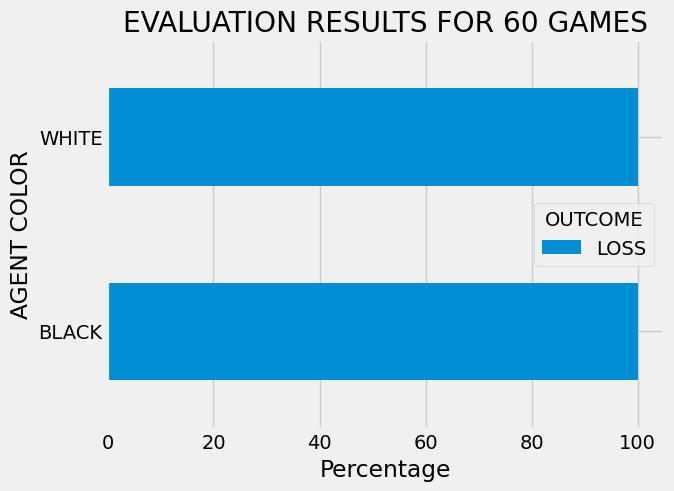

In [36]:
evaluation_results = AGENT_EVALUATION(Stockfish_path, dqn_agent, n_evaluations=30)

In [37]:
evaluation_results

,AGENT COLOR,OUTCOME,N STEPS
0,WHITE,LOSS,23
1,BLACK,LOSS,20
2,WHITE,LOSS,26
3,BLACK,LOSS,22
4,WHITE,LOSS,21
5,BLACK,LOSS,21
6,WHITE,LOSS,24
7,BLACK,LOSS,7
8,WHITE,LOSS,13
9,BLACK,LOSS,12


# Transfer learning